In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib
import string
import os.path
import statsmodels.api as sm
from copy import deepcopy
import attr

import rpy2.robjects as ro
Rload = ro.r('readRDS')
from rpy2.robjects import pandas2ri
pandas2ri.activate()

from uncertaintyFunctions import *
from constants import *

%matplotlib inline

/Users/naomi/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
font = {'family' : 'serif',
        'serif' : 'Times',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

## First, global mean annual mean temperature 

## To make a plot with all default options, here is the minimum that you need to specify.

/Users/naomi/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


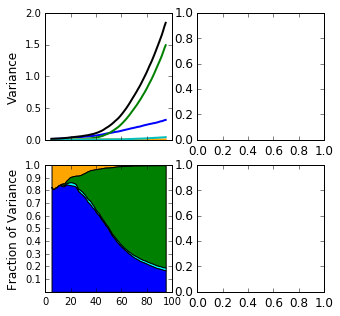

In [3]:
field = 'tas'
region = 'global'

options = defaults()

nColumns = 2
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))

column = 0
plotColumn(ax,column,field,region,options)


### Note that nColumns must be >=2 or the axes object will not have the correct dimensions that some of the functions expect.

## Now plot this for several methods and sets of input data, using confidence intervals and an extra row of plots of the input time-series, spaghetti plot style for all four scenarios.

/Users/naomi/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


internal variance CMIP5  :  0.00342256201724  range:  0.00266998970411 0.00421011288183
internal variance CMIP5 -all+LE :  0.00378118319514  range:  0.00309757442126 0.00452584338984
internal variance CMIP5 -1run+LE :  0.00495194931947  range:  0.00292663037588 0.00698608414626
internal variance H&S smoothed method:  0.00676566882582
internal variance H&S default method:  0.00442696276249


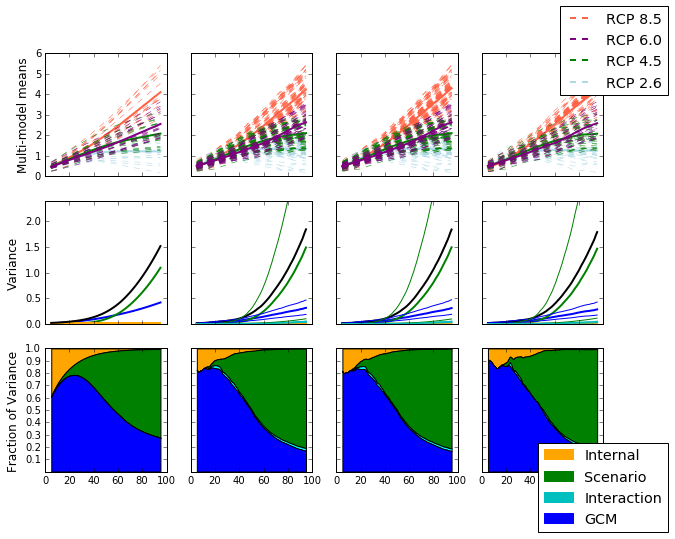

In [4]:
field = 'tas'
region = 'global'

options = defaults(nRows=3,season='annual',confidenceIntervals=True,ylimVariance=[0,2.4], \
                  ylimMeanRow=[0,6],spaghetti=True,scenarios=['rcp85','rcp26','rcp45','rcp60'])

nColumns = 4
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,
                       figsize=(2.5*nColumns,2.5*options.nRows))

column = 1
plotColumn(ax,column,field,region,options)
column = 2
options.ensemble='-all+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
column = 3
options.ensemble='-1run+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)

column = 0
options.HandS=True
attr.validate(options)
plotColumn(ax,column,field,region,options)
#also print the value gotten with the H&S 4th order polynomial:
options.internal='default'
anomaly = getAnomaly(field,region,options)
internalComponent, modelComponent, scenarioComponent, smoothed = getVariancesHandS(region,anomaly,options)

plotLegend(fig)

### The only options for nRows are 2 or 3. Three will give you the extra row at the top.
### Note that if you plot multiple columns, axis ticks are only labeled on the left-most, but all the columns might have (unlabeled) different y-scales. For this reason you should specify ylimVariance, and ylimMeanRow (if there's an extra first row), so that all columns have the same y-limits for a given row.

## For fun, let's print the variance between runs by model for one scenario.

In [5]:
smoothed = getSmoothed('tas','global',defaults()) 

for model in smoothed['rcp85'].transpose().index.get_level_values('model').unique():
    numRuns = smoothed['rcp85'][model].transpose().count().mode()[0]
    if numRuns > 1:
        print model, ' \t', numRuns, '\t', smoothed['2000':'2100']['rcp85'][model].transpose().var().mean()
    

CCSM4  	6 	0.00244728545174
CESM1-CAM5  	2 	0.0020734746211
CESM1-WACCM  	3 	0.0015676870408
CNRM-CM5  	4 	0.00245647756688
CSIRO-Mk3-6-0  	10 	0.0054045400856
CanESM2  	5 	0.00234199164413
EC-EARTH  	5 	0.00211993832577
FGOALS-s2  	2 	0.00172440686436
FIO-ESM  	3 	0.0024584920959
GISS-E2-H  	2 	0.00161000252917
GISS-E2-R  	2 	0.000913837278924
HadGEM2-CC  	2 	0.0121098039669
HadGEM2-ES  	3 	0.00522235388022
IPSL-CM5A-LR  	4 	0.0037957853889
MIROC5  	3 	0.00612425633246
MPI-ESM-LR  	2 	0.00296986454476


## And the number of runs by model for each scenario

In [6]:
smoothed = getSmoothed('tas','global',defaults()) 

byModel = smoothed['20000101'::].transpose().groupby(level='model')
#construct a model list
modelList = list(smoothed.columns.levels[1]) 
print "num models: ", len(modelList)
print modelList
for model in modelList:
    print model, ": \t \t", len(list(smoothed['rcp85'][model].columns)), '\t', \
            len(list(smoothed['rcp60'][model].columns)), '\t', \
            len(list(smoothed['rcp45'][model].columns)), '\t', \
            len(list(smoothed['rcp26'][model].columns))

num models:  42
['ACCESS1-0', 'ACCESS1-3', 'BNU-ESM', 'CCSM4', 'CESM1-BGC', 'CESM1-CAM5', 'CESM1-WACCM', 'CMCC-CESM', 'CMCC-CM', 'CMCC-CMS', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'EC-EARTH', 'FGOALS-g2', 'FGOALS-s2', 'FIO-ESM', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-H-CC', 'GISS-E2-R', 'GISS-E2-R-CC', 'HadGEM2-AO', 'HadGEM2-CC', 'HadGEM2-ES', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'IPSL-CM5B-LR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC5', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'MRI-ESM1', 'NorESM1-M', 'NorESM1-ME', 'bcc-csm1-1', 'bcc-csm1-1-m', 'inmcm4']
ACCESS1-0 : 	 	1 	0 	1 	0
ACCESS1-3 : 	 	1 	0 	1 	0
BNU-ESM : 	 	1 	0 	1 	1
CCSM4 : 	 	6 	6 	6 	6
CESM1-BGC : 	 	1 	0 	1 	0
CESM1-CAM5 : 	 	2 	3 	3 	3
CESM1-WACCM : 	 	3 	0 	3 	1
CMCC-CESM : 	 	1 	0 	0 	0
CMCC-CM : 	 	1 	0 	1 	0
CMCC-CMS : 	 	1 	0 	1 	0
CNRM-CM5 : 	 	4 	0 	1 	1
CSIRO-Mk3-6-0 : 	 	10 	10 	9 	10
CanESM2 : 	 	5 	0 	5 	5
EC-EARTH : 	 	5 	0 	8 	2
FGOALS-g2 : 	 	1 	0 	1 	1
FGOALS-s2 : 	 	2 	0 	0 	0
FIO-ESM 

In [17]:
##list scenarios that exist for a given model
#smoothed.swaplevel(0,1,axis=1).swaplevel(1,2,axis=1)['ACCESS1-0']['run1'].columns.values

##list models that exist for a given scenario
#smoothed.swaplevel(1,2,axis=1)['rcp26']['run1'].columns.values

##list all runs that exist for a model/scenario pair:
#len(smoothed['rcp26']['GISS-E2-H'].columns.values)

## Global mean annual mean Precipitation

internal variance CMIP5  :  1.89745229678e-05  range:  1.48431931895e-05 2.31595613447e-05
internal variance CMIP5 -all+LE :  2.3315186963e-05  range:  1.90699730707e-05 2.78612948353e-05
internal variance CMIP5 -1run+LE :  3.74991779543e-05  range:  2.35798823324e-05 5.27029042678e-05
internal variance H&S smoothed method:  3.7496203578e-05
internal variance H&S default method:  2.4105853094e-05


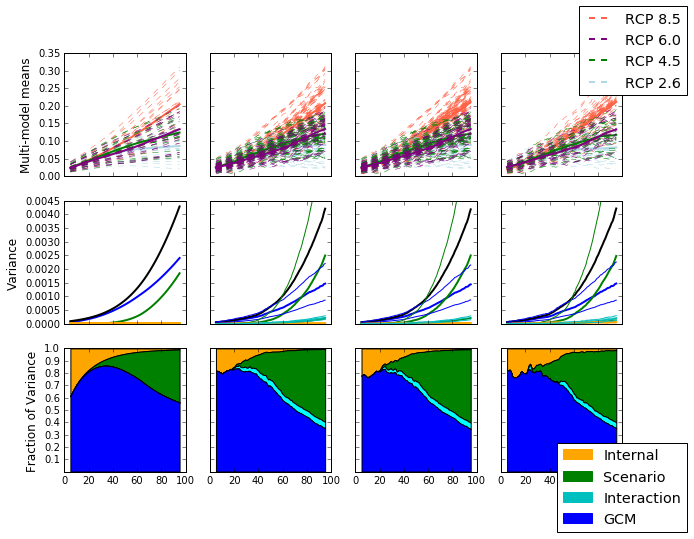

In [7]:
field = 'pr'
region = 'global'

options=defaults(nRows=3,confidenceIntervals=True,ylimVariance=[0,0.0045],ylimMeanRow=[0,0.35],
                spaghetti=True,scenarios=['rcp85','rcp26','rcp45','rcp60'])

nColumns = 4
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))

column = 1
plotColumn(ax,column,field,region,options)
column = 2
options.ensemble='-all+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
column = 3
options.ensemble='-1run+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)

column = 0
options.HandS=True
attr.validate(options)
plotColumn(ax,column,field,region,options)
#also print the value gotten with the H&S 4th order polynomial:
options.internal='default'
anomaly = getAnomaly(field,region,options)
internalComponent, modelComponent, scenarioComponent, smoothed = getVariancesHandS(region,anomaly,options)

plotLegend(fig)

## Annual mean, NW temperature:

internal variance CMIP5  :  0.0497257409425  range:  0.039128491124 0.0600844906494
internal variance CMIP5 -all+LE :  0.0501188428479  range:  0.04112814556 0.0594802104147
internal variance CMIP5 -1run+LE :  0.0479654183865  range:  0.02840344793 0.0666393850733
internal variance H&S smoothed method:  0.0717057381347
internal variance H&S default method:  0.0638564363673


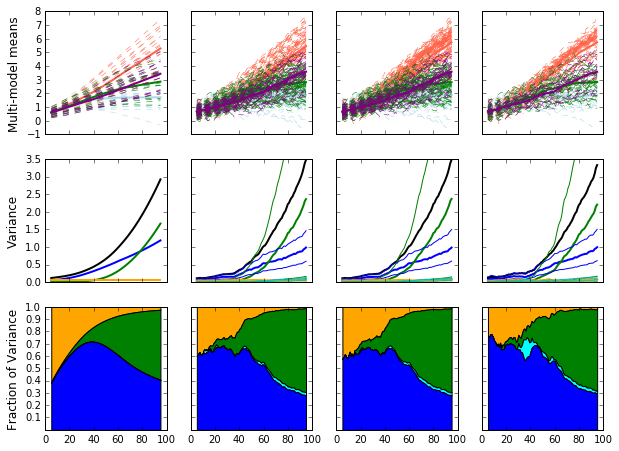

In [8]:
field = 'tas'
region = 'pnw'

options = defaults(nRows=3,season='annual',confidenceIntervals=True,ylimVariance=[0,3.5], \
                  ylimMeanRow=[-1,8],spaghetti=True,scenarios=['rcp85','rcp26','rcp45','rcp60'])

nColumns = 4
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))

column = 1
plotColumn(ax,column,field,region,options)
column = 2
options.ensemble='-all+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
column = 3
options.ensemble='-1run+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)

column = 0
options.HandS=True
attr.validate(options)
plotColumn(ax,column,field,region,options)
#also print the value gotten with the H&S 4th order polynomial:
options.internal='default'
anomaly = getAnomaly(field,region,options)
internalComponent, modelComponent, scenarioComponent, smoothed = getVariancesHandS(region,anomaly,options)


internal variance CMIP5  :  0.0497257409425  range:  0.039128491124 0.0600844906494
internal variance CMIP5 -all+LE :  0.0501188428479  range:  0.04112814556 0.0594802104147
internal variance CMIP5 -1run+LE :  0.0479654183865  range:  0.02840344793 0.0666393850733
internal variance H&S smoothed method:  0.0717057381347


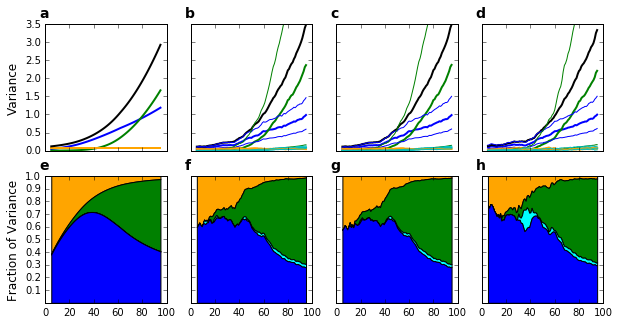

In [9]:
field = 'tas'
region = 'pnw'

options = defaults(nRows=2,season='annual',confidenceIntervals=True,ylimVariance=[0,3.5])

nColumns = 4
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 1
plotColumn(ax,column,field,region,options)
column = 2
options.ensemble='-all+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
column = 3
options.ensemble='-1run+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)

column = 0
options.HandS=True
attr.validate(options)
plotColumn(ax,column,field,region,options)

#plt.savefig('/Users/naomi/my documents/school (UW)/regional/manuscripts/uncertaintyPaper/figureS1final.eps')


# NW temperature with after-the-fact smoothing

In [10]:
len(smoothed.columns)

68

internal variance H&S smoothed method:  0.0717057381347


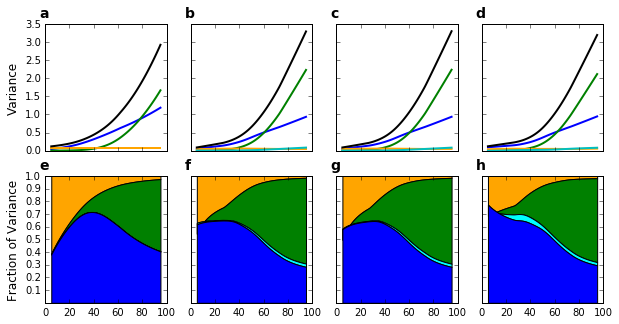

In [11]:
field = 'tas'
region = 'pnw'

options = defaults(nRows=2,season='annual',smooth=0.5,ylimVariance=[0,3.5])

nColumns = 4
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 1
plotColumn(ax,column,field,region,options)
column = 2
options.ensemble='-all+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
column = 3
options.ensemble='-1run+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)

column = 0
options.HandS=True
attr.validate(options)
plotColumn(ax,column,field,region,options)

#plt.savefig('/Users/naomi/my documents/school (UW)/regional/manuscripts/uncertaintyPaper/figure1final.eps')


## Now, annual mean NW precipitation

internal variance CMIP5  :  0.0109004619466  range:  0.0086582294266 0.0129989721379
internal variance CMIP5 -all+LE :  0.0106184707333  range:  0.00875717083408 0.0124390598952
internal variance CMIP5 -1run+LE :  0.00911260745033  range:  0.00565385945562 0.0125485603967
internal variance H&S smoothed method:  0.0129907330187


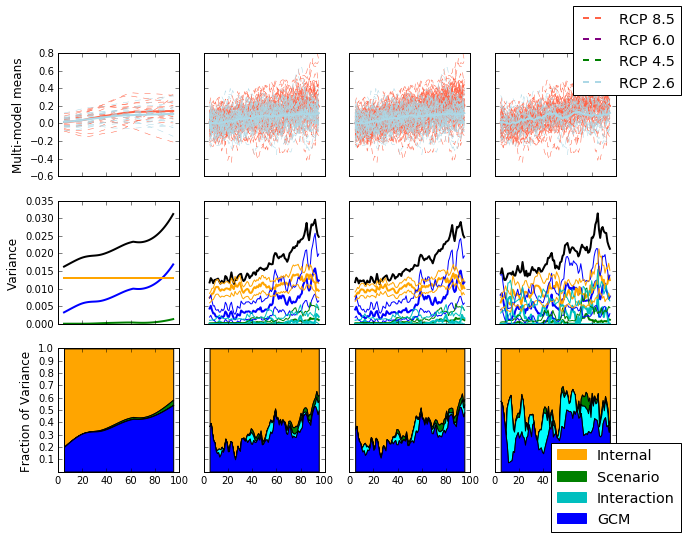

In [12]:
field = 'pr'
region = 'pnw'

options = defaults(nRows=3,confidenceIntervals=True,ylimVariance=[0,0.035], \
                   ylimMeanRow=[-0.6,0.8],spaghetti=True)

nColumns = 4
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))

column = 1
plotColumn(ax,column,field,region,options)
column = 2
options.ensemble='-all+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
column = 3
options.ensemble='-1run+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)

column = 0
options.HandS=True
attr.validate(options)
plotColumn(ax,column,field,region,options)

plotLegend(fig)

### Version for paper supplement:

internal variance CMIP5  :  0.0109004619466  range:  0.0086582294266 0.0129989721379
internal variance CMIP5 -all+LE :  0.0106184707333  range:  0.00875717083408 0.0124390598952
internal variance CMIP5 -1run+LE :  0.00911260745033  range:  0.00565385945562 0.0125485603967
internal variance H&S smoothed method:  0.0129907330187


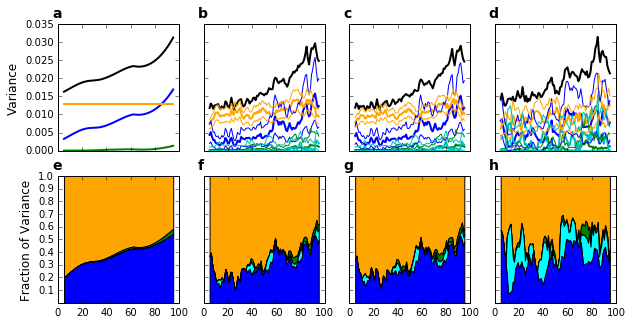

In [13]:
field = 'pr'
region = 'pnw'

options = defaults(nRows=2,confidenceIntervals=True,ylimVariance=[0,0.035])

nColumns = 4
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 1
plotColumn(ax,column,field,region,options)
column = 2
options.ensemble='-all+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
column = 3
options.ensemble='-1run+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)

column = 0
options.HandS=True
attr.validate(options)
plotColumn(ax,column,field,region,options)

#plt.savefig('/Users/naomi/my documents/school (UW)/regional/manuscripts/uncertaintyPaper/figureS2final.eps')


### Version for paper:

internal variance H&S smoothed method:  0.0129907330187


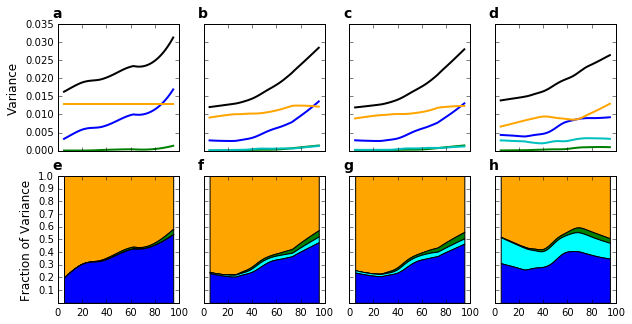

In [14]:
field = 'pr'
region = 'pnw'

options = defaults(nRows=2,smooth=0.5,ylimVariance=[0,0.035])

nColumns = 4
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 1
plotColumn(ax,column,field,region,options)
column = 2
options.ensemble='-all+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)
column = 3
options.ensemble='-1run+LE'
attr.validate(options)
plotColumn(ax,column,field,region,options)

column = 0
options.HandS=True
attr.validate(options)
plotColumn(ax,column,field,region,options)

#plt.savefig('/Users/naomi/my documents/school (UW)/regional/manuscripts/uncertaintyPaper/figure2final.eps')


## Figure out what after-the-fact smoothing to use on the N&C decadal results

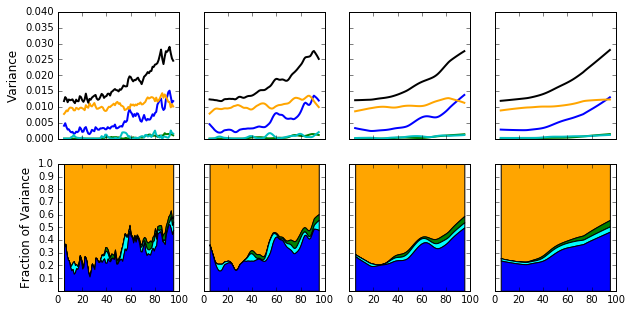

In [15]:
field = 'pr'
region = 'pnw'

options = defaults(nRows=2,ylimVariance=[0,0.04],ensemble='-all+LE')

nColumns = 4
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))

column = 0
plotColumn(ax,column,field,region,options)

column = 1
options.smooth=0.1
plotColumn(ax,column,field,region,options)

column = 2
options.smooth=0.3
plotColumn(ax,column,field,region,options)

column = 3
options.smooth=0.5
plotColumn(ax,column,field,region,options)

## Hawkins and Sutton results with a) 4th order polynomial, b) Lowess filter

internal variance H&S default method:  0.0127473993674
internal variance H&S smoothed method:  0.0129907330187


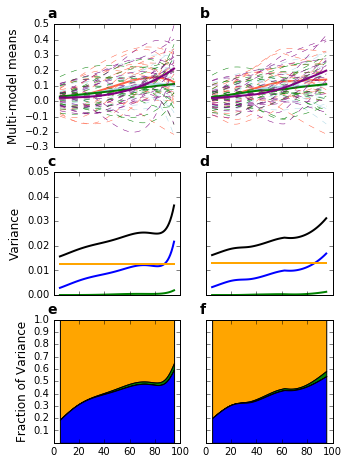

In [16]:
field = 'pr'
region = 'pnw'

options = defaults(nRows=3,ylimVariance=[0,0.05],ylimMeanRow=[-0.3,0.5],spaghetti=True, \
                  scenarios=['rcp85','rcp26','rcp45','rcp60'],HandS=True,internal='default')

nColumns = 2
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 0
plotColumn(ax,column,field,region,options)
column = 1
options.internal='smoothed'
plotColumn(ax,column,field,region,options)


## Seasons NW Precipitation: DJF, JJA
## CMIP5, all runs + CESM LE (combined ensemble)

internal variance CMIP5 -all+LE :  0.0837379994646  range:  0.0685853501881 0.0983097741476
internal variance CMIP5 -all+LE :  0.0174861547156  range:  0.0144015364867 0.0206044844685


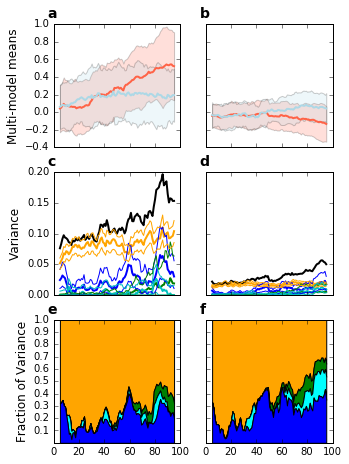

In [18]:
field = 'pr'
region = 'pnw'

options = defaults(nRows=3,confidenceIntervals=True,ylimVariance=[0,0.2], \
                   ylimMeanRow=[-0.4,1.0],ensemble='-all+LE')

nColumns = 2
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 0
options.season='DJF'
plotColumn(ax,column,field,region,options)
column = 1
options.season='JJA'
plotColumn(ax,column,field,region,options)

#plt.savefig('/Users/naomi/my documents/school (UW)/regional/manuscripts/uncertaintyPaper/figureS3final.eps')

### The multimodel means with standard deviation shading for each scenario are the default for the top row (spaghetti=False)

### Version for paper:

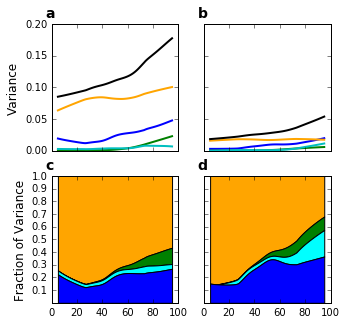

In [19]:
field = 'pr'
region = 'pnw'

options = defaults(nRows=2,smooth=0.5,ylimVariance=[0,0.2],ensemble='-all+LE')

nColumns = 2
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 0
options.season='DJF'
plotColumn(ax,column,field,region,options)
column = 1
options.season='JJA'
plotColumn(ax,column,field,region,options)

#plt.savefig('/Users/naomi/my documents/school (UW)/regional/manuscripts/uncertaintyPaper/figure3final.eps')

## Now, annual mean precipitation for all the regions:

### Version for supplement:

internal variance CMIP5 -all+LE :  0.00439489205228  range:  0.0036232249825 0.00516988298693
internal variance CMIP5 -all+LE :  0.0102058700464  range:  0.0083981256218 0.0120608011892
internal variance CMIP5 -all+LE :  0.0106184707333  range:  0.00875717083408 0.0124390598952
internal variance CMIP5 -all+LE :  0.0158644170722  range:  0.013045718811 0.0187183207137
internal variance CMIP5 -all+LE :  0.00682484768569  range:  0.00561751706566 0.008071366162


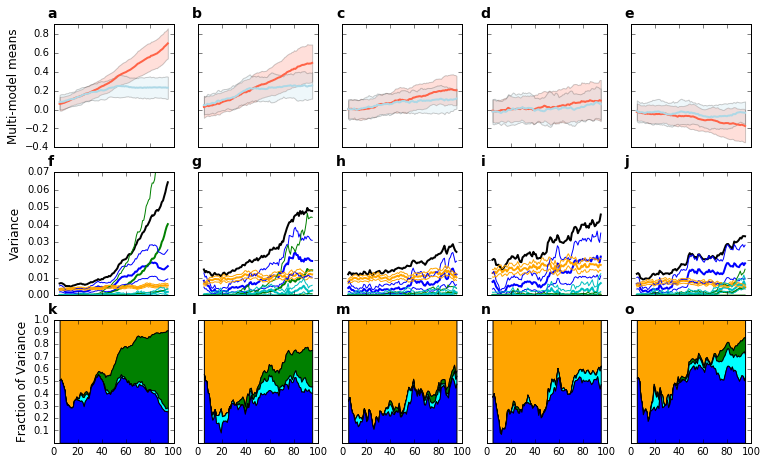

In [20]:
field = 'pr'

options = defaults(nRows=3,confidenceIntervals=True,ylimVariance=[0,0.07], \
                   ylimMeanRow=[-0.4,0.9],ensemble='-all+LE')

nColumns = 5
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 0
plotColumn(ax,column,field,'Alaska',options)
column = 1
plotColumn(ax,column,field,'BC',options)
column = 2
plotColumn(ax,column,field,'pnw',options)
column = 3
plotColumn(ax,column,field,'Cali',options)
column = 4
plotColumn(ax,column,field,'Baja',options)

#plt.savefig('/Users/naomi/my documents/school (UW)/regional/manuscripts/uncertaintyPaper/figureS4final.eps')

## afterwards smoothing, precip all regions

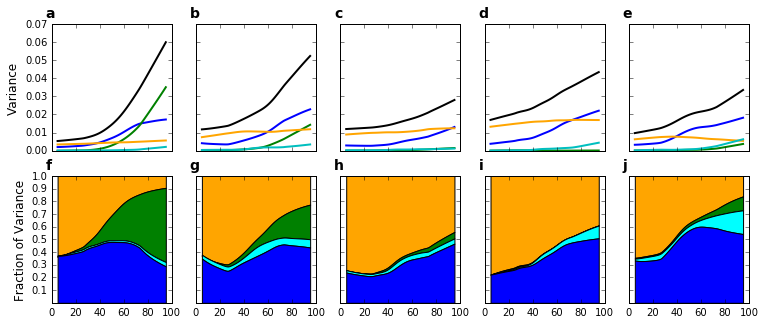

In [21]:
field = 'pr'

options = defaults(nRows=2,smooth=0.5,ylimVariance=[0,0.07],ensemble='-all+LE')

nColumns = 5
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 0
plotColumn(ax,column,field,'Alaska',options)
column = 1
plotColumn(ax,column,field,'BC',options)
column = 2
plotColumn(ax,column,field,'pnw',options)
column = 3
plotColumn(ax,column,field,'Cali',options)
column = 4
plotColumn(ax,column,field,'Baja',options)

#plt.savefig('/Users/naomi/my documents/school (UW)/regional/manuscripts/uncertaintyPaper/figure4final.eps')

## the version generated with the informative prior for scenario using BUGS:

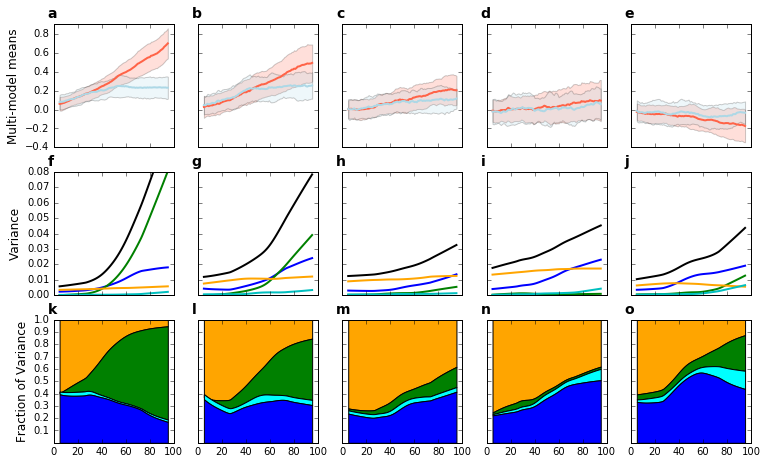

In [22]:
field = 'pr'

options = defaults(nRows=3,smooth=0.5,ylimVariance=[0,0.08],ylimMeanRow=[-0.4,0.9], \
                   ensemble='-all+LE',append='-Bayes')

nColumns = 5
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 0
plotColumn(ax,column,field,'Alaska',options)
column = 1
plotColumn(ax,column,field,'BC',options)
column = 2
plotColumn(ax,column,field,'pnw',options)
column = 3
plotColumn(ax,column,field,'Cali',options)
column = 4
plotColumn(ax,column,field,'Baja',options)


## Temperature all regions

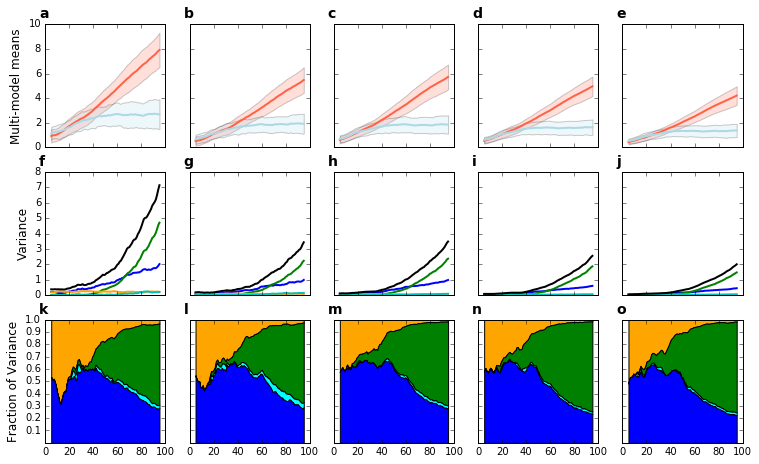

In [23]:
field = 'tas'

options = defaults(nRows=3,ylimVariance=[0,8], \
                   ylimMeanRow=[0,10],ensemble='-all+LE')

nColumns = 5
fig, ax = plt.subplots(nrows=options.nRows,ncols=nColumns,figsize=(2.5*nColumns,2.5*options.nRows))
letterSubfigures(ax)

column = 0
plotColumn(ax,column,field,'Alaska',options)
column = 1
plotColumn(ax,column,field,'BC',options)
column = 2
plotColumn(ax,column,field,'pnw',options)
column = 3
plotColumn(ax,column,field,'Cali',options)
column = 4
plotColumn(ax,column,field,'Baja',options)

